# Пример расчета прямого и обратного прохода при обучении сети.

<img src='images/ris0_1.png' width=600, heigth=440> <br>
<img src='images/ris0_2.png' width=600, heigth=440> <br>
<img src='images/ris0_3.png' width=600, heigth=440> <br>
<img src='images/ris1_1.png' width=600, heigth=440> <br>
<img src='images/ris1_2.png' width=600, heigth=440> <br>


# Открытие датасета

# Импорты
Нужно установить PyTorch 

In [34]:
import math
import csv
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms
from torchvision.transforms.functional import normalize
import torchvision.datasets as dset

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler, Sampler
from tqdm import tqdm
from sklearn.metrics import classification_report

# Load wine dataset (Scikit-learn)
from sklearn import datasets

In [35]:
raw_data = datasets.load_wine()
print("Wine dataset keys:", raw_data.keys())
print("Wine dataset type:", type(raw_data))

Wine dataset keys: dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])
Wine dataset type: <class 'sklearn.utils._bunch.Bunch'>


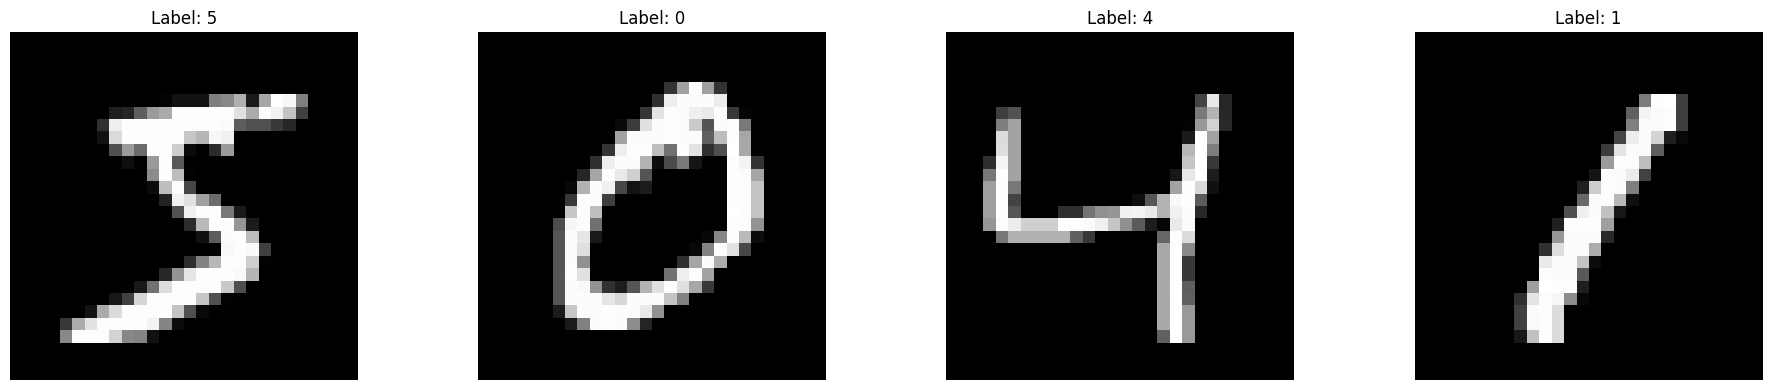

MNIST training set size: 60000 images
MNIST test set size: 10000 images
MNIST image shape: torch.Size([1, 28, 28])


In [36]:
# Load MNIST dataset
MNIST_train = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)
MNIST_test = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Display MNIST dataset (fixed warning)
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4) 
ax = []
for i in range(4):
    ax.append(fig.add_subplot(gs[i]))
    # Fixed: properly convert tensor to numpy array
    img_array = MNIST_train[i][0].squeeze().numpy()
    ax[i].imshow(img_array, cmap='gray')
    ax[i].set_title(f"Label: {MNIST_train[i][1]}")
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# Additional information about the datasets
print(f"MNIST training set size: {len(MNIST_train)} images")
print(f"MNIST test set size: {len(MNIST_test)} images")
print(f"MNIST image shape: {MNIST_train[0][0].shape}")

In [37]:
# создание класса perceptron
class Perceptron(torch.nn.Module):
    def __init__(self, input_dim=784, num_layers=0,
            hidden_dim=64, output_dim=10, p=0.0, device='cpu'): 
        super(Perceptron, self).__init__()
        self.layers = torch.nn.Sequential()
        prev_size = input_dim 
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i), torch.nn.Linear(prev_size, hidden_dim)) 
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p)) 
            prev_size = hidden_dim
        self.layers.add_module('classifier',
            torch.nn.Linear(prev_size, output_dim))
        self.to(device)

    def forward(self, input):
        return self.layers(input)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
device

device(type='cpu')

In [38]:
# Создание модели без внутренних слоев 
model = Perceptron(device=device) 
model

Perceptron(
  (layers): Sequential(
    (classifier): Linear(in_features=784, out_features=10, bias=True)
  )
)

In [39]:

model = Perceptron(num_layers=5, device=device) 
model

Perceptron(
  (layers): Sequential(
    (layer0): Linear(in_features=784, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.0, inplace=False)
    (layer1): Linear(in_features=64, out_features=64, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.0, inplace=False)
    (layer2): Linear(in_features=64, out_features=64, bias=True)
    (relu2): ReLU()
    (dropout2): Dropout(p=0.0, inplace=False)
    (layer3): Linear(in_features=64, out_features=64, bias=True)
    (relu3): ReLU()
    (dropout3): Dropout(p=0.0, inplace=False)
    (layer4): Linear(in_features=64, out_features=64, bias=True)
    (relu4): ReLU()
    (dropout4): Dropout(p=0.0, inplace=False)
    (classifier): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [40]:
# процедура терстирования модели 
def testing(model, dataset):
    generator = torch.utils.data.DataLoader(dataset, batch_size=64)
    pred = []
    real = []
    for x, y in tqdm(generator, leave=False):
        x = x.view([-1, 784]).to(device) 
        y = y.to(device)
        pred.extend(torch.argmax(model(x), dim=-1).cpu().numpy().tolist()) 
        real.extend(y.cpu().numpy().tolist())
    
    return np.mean(np.array(real) == np.array(pred)), classification_report(real, pred)

# процедура тренировки модели
def trainer(model, dataset, loss_function, optimizer, epochs): 
    for epoch in tqdm(range(epochs), leave=False):
        generator = torch.utils.data.DataLoader(dataset, batch_size=64,
            shuffle=True)

        for x, y in tqdm(generator, leave=False):
            optimizer.zero_grad() 
            x = x.view([-1, 784]).to(device) 
            y = y.to(device)
            output = model(x)
            loss = loss_function(output, y)
            loss.backward()
            optimizer.step()
            
model = Perceptron(num_layers=0, device=device)

# Результат, получаемый от необученной модели.
_ = model.eval()
acc, report = testing(model, MNIST_test) 
print(report)

              precision    recall  f1-score   support

           0       0.06      0.09      0.07       980
           1       0.06      0.04      0.05      1135
           2       0.24      0.20      0.22      1032
           3       0.33      0.26      0.29      1010
           4       0.32      0.02      0.03       982
           5       0.11      0.37      0.17       892
           6       0.13      0.00      0.01       958
           7       0.02      0.01      0.02      1028
           8       0.11      0.09      0.10       974
           9       0.15      0.18      0.16      1009

    accuracy                           0.12     10000
   macro avg       0.15      0.13      0.11     10000
weighted avg       0.15      0.12      0.11     10000



In [41]:
# Обучение модели
_ = model.train()
trainer(model=model,
    dataset=MNIST_train,
    loss_function=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001), 
    epochs=4)

# Результат обучения классификатора
_ = model.eval()
acc, report = testing(model, MNIST_test) 
print(report)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.92      0.90      0.91      1032
           3       0.88      0.92      0.90      1010
           4       0.92      0.93      0.93       982
           5       0.92      0.85      0.88       892
           6       0.93      0.96      0.94       958
           7       0.93      0.92      0.92      1028
           8       0.89      0.88      0.88       974
           9       0.90      0.90      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



Задание: С помощью нейронной сети классифицировать вина по качеству. Датасет взять из третьей работы. Разбить датасет на два класса по качеству вина. Качество вина до пяти включительно определить как первый класс, свыше пяти - как второй.
Представить основные показатели метода. Сравнить результат классификации с результатом из третьей работы.

Первые 5 строк датасета:
   Wine  Alcohol  Malic.acid   Ash   Acl   Mg  Phenols  Flavanoids  \
0     1    14.23        1.71  2.43  15.6  127     2.80        3.06   
1     1    13.20        1.78  2.14  11.2  100     2.65        2.76   
2     1    13.16        2.36  2.67  18.6  101     2.80        3.24   
3     1    14.37        1.95  2.50  16.8  113     3.85        3.49   
4     1    13.24        2.59  2.87  21.0  118     2.80        2.69   

   Nonflavanoid.phenols  Proanth  Color.int   Hue    OD  Proline  
0                  0.28     2.29       5.64  1.04  3.92     1065  
1                  0.26     1.28       4.38  1.05  3.40     1050  
2                  0.30     2.81       5.68  1.03  3.17     1185  
3                  0.24     2.18       7.80  0.86  3.45     1480  
4                  0.39     1.82       4.32  1.04  2.93      735  

Информация о датасете:
<class 'pandas.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Nul

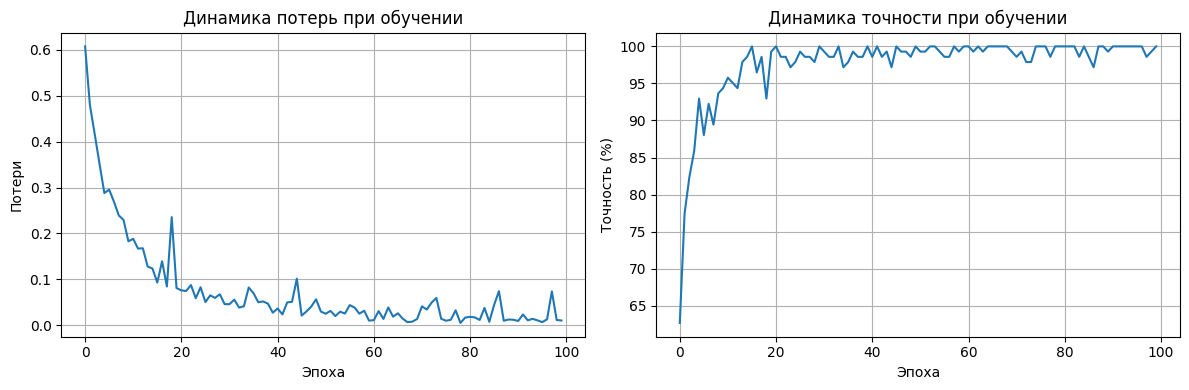

Точность на тестовых данных: 0.9722 (97.22%)

Матрица ошибок:
[[23  1]
 [ 0 12]]

Отчет по классификации:
                    precision    recall  f1-score   support

Класс 0 (Wine=2,3)       1.00      0.96      0.98        24
  Класс 1 (Wine=1)       0.92      1.00      0.96        12

          accuracy                           0.97        36
         macro avg       0.96      0.98      0.97        36
      weighted avg       0.97      0.97      0.97        36



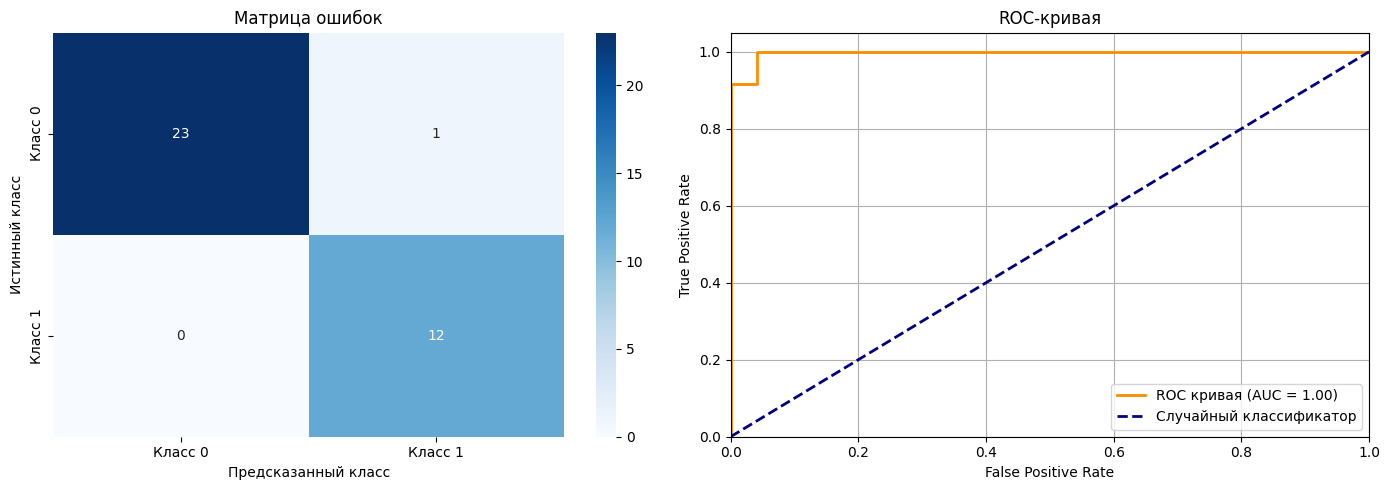

СРАВНЕНИЕ РЕЗУЛЬТАТОВ

Результаты нейронной сети (текущая работа):
- Точность: 0.9722 (97.22%)
- Precision (среднее): 0.9615
- Recall (среднее): 0.9792
- F1-score (среднее): 0.9694
- AUC-ROC: 0.9965

Результаты из 3-й работы:
- Точность: 0.6146 (61.46%)
- Precision (среднее): 0.2800
- Recall (среднее): 0.2800
- F1-score (среднее): 0.2700
СРАВНИТЕЛЬНЫЙ АНАЛИЗ:
Нейронная сеть показала точность на 35.76% ВЫШЕ, чем метод из 3-й работы


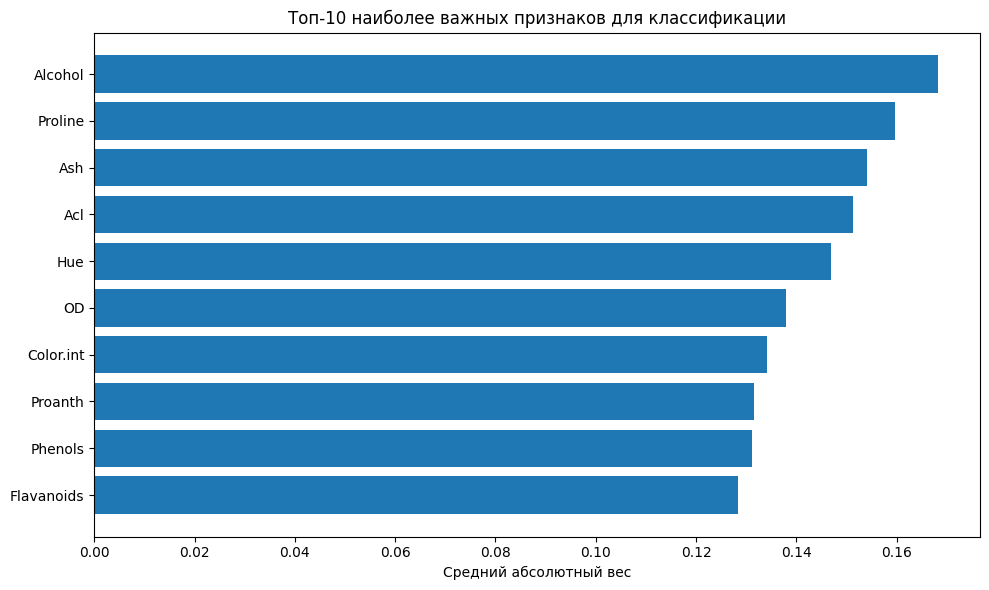

Наиболее важные признаки для определения класса вина:
1. Alcohol: 0.1682
2. Proline: 0.1597
3. Ash: 0.1541
4. Acl: 0.1512
5. Hue: 0.1470


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

wine_data = pd.read_csv('data/wine/wine.csv')

print("Первые 5 строк датасета:")
print(wine_data.head())
print("\nИнформация о датасете:")
print(wine_data.info())
print("\nСтатистика по классам вин:")
print(wine_data['Wine'].value_counts().sort_index())

wine_data['target_binary'] = (wine_data['Wine'] == 1).astype(int)  # 1 - вино класса 1, 0 - вина классов 2 и 3

print("\nРаспределение классов после бинаризации:")
print(f"Класс 1 (Wine = 1): {sum(wine_data['target_binary'] == 1)} образцов")
print(f"Класс 0 (Wine = 2 или 3): {sum(wine_data['target_binary'] == 0)} образцов")

feature_columns = [col for col in wine_data.columns if col not in ['Wine', 'target_binary']]
X = wine_data[feature_columns].values
y = wine_data['target_binary'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nРазмер обучающей выборки: {X_train_scaled.shape}")
print(f"Размер тестовой выборки: {X_test_scaled.shape}")
print(f"Количество признаков: {X_train_scaled.shape[1]}")

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

class WineClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[32, 16], dropout_rate=0.2):
        super(WineClassifier, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, 2))  # 2 класса
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)
    
    def predict(self, x):
        with torch.no_grad():
            outputs = self.forward(x)
            _, predicted = torch.max(outputs, 1)
        return predicted
    
    def predict_proba(self, x):
        with torch.no_grad():
            outputs = self.forward(x)
            return torch.softmax(outputs, dim=1)
        
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    train_losses = []
    train_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        if (epoch + 1) % 20 == 0:
            print(f'Эпоха [{epoch+1}/{epochs}], Потери: {epoch_loss:.4f}, Точность: {epoch_acc:.2f}%')
    
    return train_losses, train_accuracies

def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
            all_probabilities.extend(probabilities.numpy())
    
    return np.array(all_predictions), np.array(all_labels), np.array(all_probabilities)

input_dim = X_train_scaled.shape[1] 
hidden_dims = [32, 16] 
dropout_rate = 0.2
learning_rate = 0.001
epochs = 100

model = WineClassifier(input_dim, hidden_dims, dropout_rate)
print("Архитектура модели:")
print(model)

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.FloatTensor(class_weights)

print(f"\nВеса классов (для борьбы с дисбалансом):")
print(f"Класс 0: {class_weights[0]:.4f}")
print(f"Класс 1: {class_weights[1]:.4f}")

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("\nНачало обучения...")
train_losses, train_accuracies = train_model(
    model, train_loader, criterion, optimizer, epochs
)
print("Обучение завершено!")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses)
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Потери')
ax1.set_title('Динамика потерь при обучении')
ax1.grid(True)

ax2.plot(train_accuracies)
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('Точность (%)')
ax2.set_title('Динамика точности при обучении')
ax2.grid(True)

plt.tight_layout()
plt.show()

predictions, true_labels, probabilities = evaluate_model(model, test_loader)

accuracy = np.mean(predictions == true_labels)
print(f"Точность на тестовых данных: {accuracy:.4f} ({accuracy*100:.2f}%)")

cm = confusion_matrix(true_labels, predictions)
print("\nМатрица ошибок:")
print(cm)

print("\nОтчет по классификации:")
print(classification_report(true_labels, predictions, 
                          target_names=['Класс 0 (Wine=2,3)', 'Класс 1 (Wine=1)']))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Класс 0', 'Класс 1'],
            yticklabels=['Класс 0', 'Класс 1'])
ax1.set_xlabel('Предсказанный класс')
ax1.set_ylabel('Истинный класс')
ax1.set_title('Матрица ошибок')

fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
roc_auc = auc(fpr, tpr)

ax2.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC кривая (AUC = {roc_auc:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Случайный классификатор')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC-кривая')
ax2.legend(loc="lower right")
ax2.grid(True)

plt.tight_layout()
plt.show()

print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ")

print("\nРезультаты нейронной сети (текущая работа):")
print(f"- Точность: {accuracy:.4f} ({accuracy*100:.2f}%)")
report_dict = classification_report(true_labels, predictions, output_dict=True)
print(f"- Precision (среднее): {report_dict['macro avg']['precision']:.4f}")
print(f"- Recall (среднее): {report_dict['macro avg']['recall']:.4f}")
print(f"- F1-score (среднее): {report_dict['macro avg']['f1-score']:.4f}")
print(f"- AUC-ROC: {roc_auc:.4f}")

results_lab3 = {
    'accuracy': 0.6146,  
    'precision': 0.28,   
    'recall': 0.28,      
    'f1': 0.27,         
    'auc_roc': None,
    'best_k': 1
}

print("\nРезультаты из 3-й работы:")
print(f"- Точность: {results_lab3['accuracy']:.4f} ({results_lab3['accuracy']*100:.2f}%)")
print(f"- Precision (среднее): {results_lab3['precision']:.4f}")
print(f"- Recall (среднее): {results_lab3['recall']:.4f}")
print(f"- F1-score (среднее): {results_lab3['f1']:.4f}")

print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ:")

# Сравнение точности
accuracy_diff = accuracy - results_lab3['accuracy']
if accuracy_diff > 0:
    print(f"Нейронная сеть показала точность на {accuracy_diff*100:.2f}% ВЫШЕ, чем метод из 3-й работы")
elif accuracy_diff < 0:
    print(f"Нейронная сеть показала точность на {abs(accuracy_diff)*100:.2f}% НИЖЕ, чем метод из 3-й работы")
else:
    print("= Точность нейронной сети совпадает с результатом из 3-й работы")
    
weights = model.model[0].weight.data.numpy()
feature_importance = np.abs(weights).mean(axis=0)
feature_names = feature_columns  

sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(10), feature_importance[sorted_idx[:10]])
plt.yticks(range(10), [feature_names[i] for i in sorted_idx[:10]])
plt.xlabel('Средний абсолютный вес')
plt.title('Топ-10 наиболее важных признаков для классификации')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Наиболее важные признаки для определения класса вина:")
for i, idx in enumerate(sorted_idx[:5]):
    print(f"{i+1}. {feature_names[idx]}: {feature_importance[idx]:.4f}")